<a href="https://colab.research.google.com/github/castrokelly/eEDB-001-2023-4/blob/main/Cidades_Submersas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cidades Submersas - Brasil

##Oportunidade de Uso de Aprendizagem de Máquina

**eEDB-001-2023-4 Análise e Mineração de Dados**

Prof. Luiz Sérgio → luizsds@usp.br


Felipe Itiro Motobayashi → felipe.motobayashi@usp.br - n° USP: 97413

Gabriel Bravim Furlan → gabriel.b.furlan@usp.br - n° USP: 96925

Kelly Christine Alvarenga de Castro → kelly.castro@usp.br - n° USP: 14286221

Nikolas Gomes de Sá → nikolas_sa@usp.br - n° USP: 14702617

Este projeto visa analisar o impacto do aumento do nível do mar sobre as cidades brasileiras, utilizando aprendizagem de máquina para prever em qual ano cidades no Brasil podem ficar submersas. A análise utiliza dois conjuntos de dados: um sobre o nível do mar global e outro detalhando informações sobre cidades brasileiras.

A aplicação de aprendizagem de máquina neste contexto permite prever futuros cenários com base em tendências atuais, oferecendo informações cruciais para planejamento urbano, medidas de prevenção e adaptação às mudanças climáticas.

Os dados estão disponibilizados na plataforma Kaggle:

https://www.kaggle.com/datasets/kkhandekar/global-sea-level-1993-2021

https://www.kaggle.com/datasets/crisparada/brazilian-cities/

Informações obre o indicador GMSL: https://sealevel.colorado.edu/presentation/what-definition-global-mean-sea-level-gmsl-and-its-rate

Inspiração para o modelo: https://horizons.hdr.undp.org/?_gl=1*8vpglc*_ga*MTU2MjgxNTk2Ni4xNzAyNTExMDM3*_ga_3W7LPK0WP1*MTcwMjUxMTAzNy4xLjEuMTcwMjUxMTA1Ni40MS4wLjA.#/country/BRA

#Aprendizado de Máquina Supervisionado: Regressão

In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Bibliotecas


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from imblearn.over_sampling import SMOTE
from tabulate import tabulate
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


#Carregamento dos dados

Dados sobre o Nível do Mar Global (`sea_level`): Focaremos no GlobalMeanSeaLevel ao longo dos anos.

In [14]:
sea_level = pd.read_csv('/content/sealevel.csv', encoding='utf-8', sep=',')

Dados das Cidades Brasileiras (`brazil_cities`): Nos concentraremos na altitude das cidades (ALT).

In [15]:
brazil_cities = pd.read_csv('/content/BRAZIL_CITIES_REV2022.CSV', encoding='utf-8', sep=',')

# Análises Descritivas

In [16]:
sea_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         1048 non-null   int64  
 1   TotalWeightedObservations    1048 non-null   float64
 2   GMSL_noGIA                   1048 non-null   float64
 3   StdDevGMSL_noGIA             1048 non-null   float64
 4   SmoothedGSML_noGIA           1048 non-null   float64
 5   GMSL_GIA                     1048 non-null   float64
 6   StdDevGMSL_GIA               1048 non-null   float64
 7   SmoothedGSML_GIA             1048 non-null   float64
 8   SmoothedGSML_GIA_sigremoved  1048 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 73.8 KB


In [17]:
brazil_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5578 entries, 0 to 5577
Data columns (total 81 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CITY                    5578 non-null   object 
 1   STATE                   5578 non-null   object 
 2   CAPITAL                 5578 non-null   int64  
 3   IBGE_RES_POP            5578 non-null   int64  
 4   IBGE_RES_POP_BRAS       5578 non-null   int64  
 5   IBGE_RES_POP_ESTR       5578 non-null   int64  
 6   IBGE_DU                 5578 non-null   int64  
 7   IBGE_DU_URBAN           5578 non-null   int64  
 8   IBGE_DU_RURAL           5578 non-null   int64  
 9   IBGE_POP                5578 non-null   int64  
 10  IBGE_1                  5578 non-null   int64  
 11  IBGE_1-4                5578 non-null   int64  
 12  IBGE_5-9                5578 non-null   int64  
 13  IBGE_10-14              5578 non-null   int64  
 14  IBGE_15-59              5578 non-null   

**Dados do Nível do Mar**

Período: 1993 - 2021

Média do Nível Médio Global do Mar (GMSL_noGIA): 4.65 mm

Desvio Padrão do GMSL_noGIA: 87.01 mm

Média do GMSL Suavizado (com e sem ajuste de isostasia glacial): Varia entre 4.70 mm e 8.21 mm

In [18]:
sea_level.describe()

,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,2006.742366,326568.269981,4.645515,87.007700,4.702004,8.112557,87.062805,8.168273,8.213044
std,8.231978,28044.226934,26.351001,5.525201,26.171990,28.310139,5.557840,28.138879,27.976127
min,1993.000000,906.100000,-44.390000,77.410000,-39.780000,-43.140000,77.420000,-39.770000,-39.110000
25%,2000.000000,327418.897500,-18.250000,83.510000,-17.882500,-16.615000,83.617500,-16.087500,-17.440000
50%,2007.000000,331979.205000,1.930000,85.925000,1.505000,5.465000,85.935000,5.065000,5.170000
75%,2014.000000,335243.865000,25.857500,88.602500,26.115000,30.942500,88.732500,31.095000,29.697500
max,2021.000000,341335.090000,57.920000,118.720000,56.310000,64.390000,118.760000,63.070000,60.560000


**Dados das Cidades Brasileiras**

Número de Cidades: 5578

População Média (IBGE_RES_POP): Aproximadamente 34.223 habitantes

Número Médio de Unidades Domiciliares (IBGE_DU): Aproximadamente 10.283

População Total Média (IBGE_POP): Aproximadamente 27.553 habitantes

In [19]:
brazil_cities.describe()

,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,...,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
count,5578.000000,5.578000e+03,5.578000e+03,5578.000000,5.578000e+03,5.578000e+03,5578.000000,5.578000e+03,5578.000000,5578.000000,...,5578.000000,5.578000e+03,5.578000e+03,5.578000e+03,5.578000e+03,5578.000000,5578.000000,5578.000000,5578.000000,5578.000000
mean,0.005916,3.422313e+04,3.414573e+04,77.404625,1.028313e+04,8.842319e+03,1440.807458,2.755270e+04,382.669236,1542.089100,...,0.947293,5.500436e+09,3.598663e+09,9.839788e+03,4.869557e+03,5.739871,0.022409,0.127465,0.037827,2.035497
std,0.076695,2.028829e+05,2.012627e+05,1793.789719,6.469199e+04,6.428575e+04,1690.483808,1.857468e+05,2324.175869,9242.622881,...,1.069279,2.775752e+11,1.164327e+11,9.175728e+04,2.091673e+04,55.301718,0.148024,2.151446,0.533446,4.378558
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.217000e+03,5.214000e+03,0.000000,1.565250e+03,8.700000e+02,469.250000,2.784250e+03,38.000000,158.000000,...,0.000000,0.000000e+00,0.000000e+00,5.990000e+02,5.880000e+02,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.092650e+04,1.091600e+04,0.000000,3.167000e+03,1.839500e+03,916.000000,6.156000e+03,92.000000,376.000000,...,1.000000,0.000000e+00,2.319925e+07,1.431500e+03,1.280000e+03,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,2.340900e+04,2.338000e+04,10.000000,6.722500e+03,4.618750e+03,1811.750000,1.529875e+04,232.000000,949.750000,...,2.000000,4.774853e+07,1.991191e+08,4.084000e+03,3.292750e+03,1.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.125350e+07,1.113378e+07,119727.000000,3.576148e+06,3.548433e+06,33809.000000,1.046364e+07,129464.000000,514794.000000,...,8.000000,1.947077e+13,8.016164e+12,5.740995e+06,1.134570e+06,3236.000000,1.000000,130.000000,26.000000,225.000000


In [20]:
sea_level.sample(10)

,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
666,2011,334478.31,4.76,90.63,4.10,9.12,90.40,8.50,10.02
529,2007,332442.31,-1.76,83.07,-1.98,1.74,83.00,1.52,5.56
168,1997,326960.81,-20.35,94.87,-20.53,-19.23,94.92,-19.42,-19.25
490,2006,333935.91,-6.44,86.45,-4.74,-3.18,86.26,-1.50,1.87
256,1999,330571.91,-17.09,83.54,-17.85,-15.39,83.54,-16.15,-17.10
980,2019,331830.31,57.01,88.33,54.60,63.47,88.90,61.06,58.29
691,2011,331318.31,19.98,89.71,16.01,24.57,90.07,20.59,15.50
1038,2021,336371.50,49.00,86.66,49.35,55.87,86.15,56.22,58.44
554,2008,336290.69,1.15,85.49,0.03,4.81,85.42,3.70,4.89
785,2014,335506.59,17.62,84.61,18.10,22.81,84.63,23.30,27.07


In [21]:
brazil_cities.sample(10)

,CITY,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,...,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
1081,Carmo,RJ,0,17434,17434,0,5745,4475,1270,15113,...,1,81298750,44541052,3199,1377,0,0,0,0,4
1918,Governador Valadares,MG,0,263689,263006,683,81843,78903,2940,248674,...,2,1561191439,6451342792,61022,54686,2,1,1,0,21
5321,Ubarana,SP,0,5289,5289,0,1605,1454,151,4844,...,0,0,0,1621,489,0,0,0,0,1
4384,Santa Luz,PI,0,5513,5513,0,1466,834,632,3101,...,0,0,0,208,682,1,0,0,0,1
3639,Paulo De Faria,SP,0,8589,8589,0,2882,2601,281,7692,...,1,203344669,48117456,2695,488,0,0,0,0,1
3651,Pedra,PE,0,20944,20944,0,5786,3530,2256,11956,...,1,0,50897734,1285,1655,0,0,0,0,5
638,Bom Jardim De Goiás,GO,0,8423,8423,0,2848,2146,702,6313,...,1,23390432,99793499,1299,1682,0,0,0,0,1
3468,Pacoti,CE,0,11607,11607,0,3060,1225,1835,2931,...,1,0,21225616,648,2087,0,0,0,0,4
2817,Madre De Deus,BA,0,17376,17376,0,5179,5035,144,16807,...,2,0,104337854,1726,652,1,0,0,0,1
1261,Colinas Do Sul,GO,0,3523,3523,0,1127,776,351,2403,...,0,0,0,372,198,0,0,0,0,2


In [22]:
sea_level.shape

(1048, 9)

In [23]:
brazil_cities.shape

(5578, 81)

In [24]:
print("tamanho sea_level:",sea_level.size,"\ntamanho brazil_cities:",brazil_cities.size)

tamanho sea_level: 9432 
tamanho brazil_cities: 451818


Colunas relevantes selecionadas e renomeadas para facilitar as análises:

Year: Ano das observações

MeanSeaLevel: Média do nível do mar

StdDevSeaLevel: Desvio padrão do nível do mar

SmoothedSeaLevel: Nível do mar suavizado

In [25]:
sea_level_df_cleaned = sea_level[["Year", "GMSL_noGIA", "StdDevGMSL_noGIA", "SmoothedGSML_noGIA"]].copy()
sea_level_df_cleaned.columns = ["Year", "MeanSeaLevel", "StdDevSeaLevel", "SmoothedSeaLevel"]


Colunas relevantes selecionadas e renomeadas:

City: Nome da cidade

State: Estado

ResidentPopulation: População residente

ALT: Altitude

In [26]:
brazil_cities_df_cleaned = brazil_cities[["CITY", "STATE", "IBGE_RES_POP", "ALT"]].copy()
brazil_cities_df_cleaned.columns = ["City", "State", "ResidentPopulation", "ALT"]

Visualizando as primeiras linhas dos dataframes com as colunas alteradas:

In [27]:
sea_level_df_cleaned_head = sea_level_df_cleaned.head()
brazil_cities_df_cleaned_head = brazil_cities_df_cleaned.head()

sea_level_df_cleaned_head, brazil_cities_df_cleaned_head

(   Year  MeanSeaLevel  StdDevSeaLevel  SmoothedSeaLevel
 0  1993        -38.59           89.86            -38.76
 1  1993        -41.97           90.86            -39.78
 2  1993        -41.93           87.27            -39.62
 3  1993        -42.67           90.75            -39.67
 4  1993        -37.86           90.26            -38.75,
                   City State  ResidentPopulation        ALT
 0      Abadia De Goiás    GO                6876   893.6015
 1  Abadia Dos Dourados    MG                6704   753.1249
 2            Abadiânia    GO               15757  1017.5506
 3           Abaetetuba    PA              141100    10.1203
 4               Abaeté    MG               22690   644.7399)

Produrando por valores faltantes:

In [28]:
missing_values_sea_level = sea_level.isnull().sum()
missing_values_brazil_cities = brazil_cities.isnull().sum()

missing_values_sea_level, missing_values_brazil_cities

(Year                           0
 TotalWeightedObservations      0
 GMSL_noGIA                     0
 StdDevGMSL_noGIA               0
 SmoothedGSML_noGIA             0
 GMSL_GIA                       0
 StdDevGMSL_GIA                 0
 SmoothedGSML_GIA               0
 SmoothedGSML_GIA_sigremoved    0
 dtype: int64,
 CITY                 0
 STATE                0
 CAPITAL              0
 IBGE_RES_POP         0
 IBGE_RES_POP_BRAS    0
                     ..
 Wheeled_tractor      0
 UBER                 0
 MAC                  0
 WAL-MART             0
 POST_OFFICES         0
 Length: 81, dtype: int64)

#Tendência

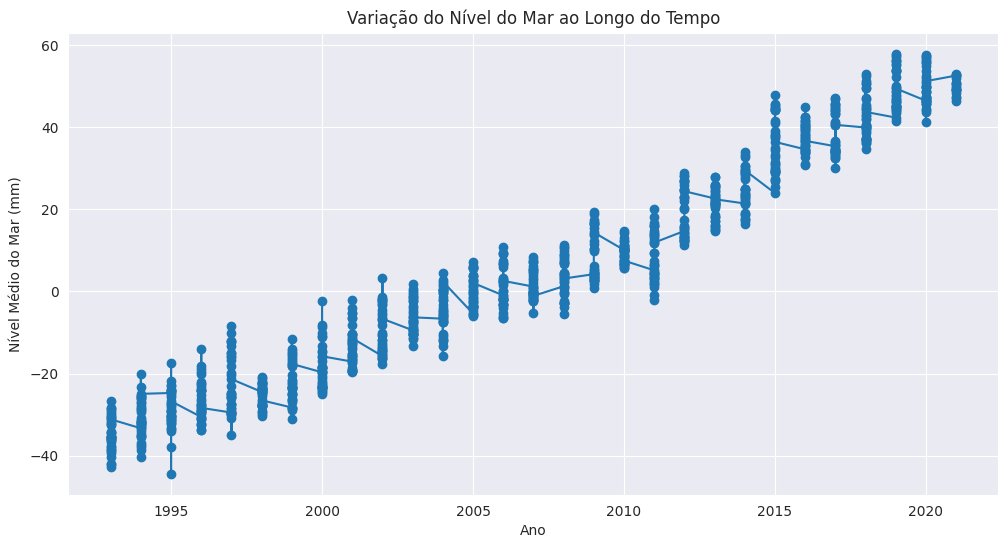

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(sea_level_df_cleaned['Year'], sea_level_df_cleaned['MeanSeaLevel'], marker='o')
plt.title('Variação do Nível do Mar ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Nível Médio do Mar (mm)')
plt.grid(True)
plt.show()

#Modelo de Regressão Linear para Previsão do Nível do Mar

Para criar um modelo preditivo que estime a probabilidade de submersão de cidades brasileiras devido ao aumento do nível do mar, precisamos primeiro definir a variável dependente `(target)` e as variáveis independentes `(features)`. Neste caso, a variável dependente seria a probabilidade de submersão de uma cidade, e as variáveis independentes poderiam incluir o nível do mar e a altitude das cidades.

In [30]:
X = sea_level_df_cleaned[['Year']]
y = sea_level_df_cleaned['MeanSeaLevel']

In [31]:
# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
# Criando o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [33]:
# Realizando previsões com o modelo
y_pred = model.predict(X_test)

In [34]:
# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


O modelo de regressão linear foi treinado para prever a variação do nível médio global do mar (GMSL_noGIA) com base no ano. Os resultados são os seguintes:


*   Mean Squared Error (MSE): `38.26`
*   Coeficiente de Determinação (R²): `0.94`

**O valor de R² próximo de 1 indica que o modelo é bastante eficaz em capturar a variação do nível do mar ao longo do tempo.**

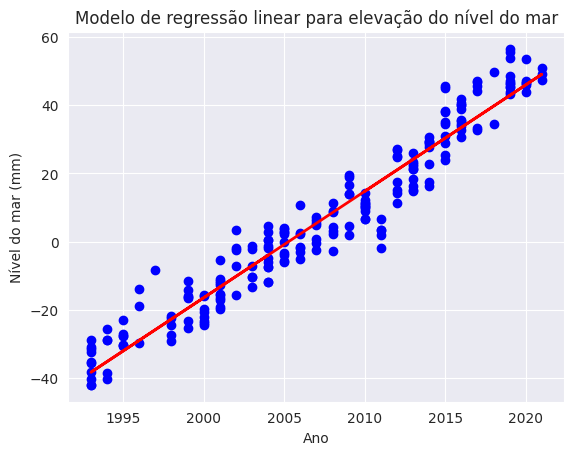

(38.2562272338931, 0.9399584206781438)

In [35]:
# Plotando os resultados
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('Ano')
plt.ylabel('Nível do mar (mm)')
plt.title('Modelo de regressão linear para elevação do nível do mar')
plt.show()

mse, r2

Gráfico do Modelo

O gráfico mostra os dados reais (em azul) e as previsões do modelo (em vermelho). Observa-se uma clara tendência linear, indicando que o modelo conseguiu capturar bem a relação entre o ano e a variação do nível do mar.

# Previsão do Nível do Mar para Anos Futuros

In [48]:
future_years = np.array([2025, 2030, 2035]).reshape(-1, 1)

In [36]:
# Gerando previsões de nível do mar de 2022 a 2050
future_years_extended = np.arange(2022, 2051).reshape(-1, 1)
predicted_sea_levels_extended = model.predict(future_years_extended)

# Análise de Correlação

In [37]:
# Criando um DataFrame para armazenar as correlações
correlations = pd.DataFrame(columns=['Year', 'Correlation'])

In [38]:
# Usando o valor do nível do mar mais recente para correlação
most_recent_sea_level = sea_level_df_cleaned['MeanSeaLevel'].iloc[-1]

In [39]:
# Adicionando este valor a todas as cidades no DataFrame 'brazil_cities_df_cleaned'
brazil_cities_df_cleaned['RecentSeaLevel'] = most_recent_sea_level

In [40]:
## Cálculo da correlação
correlation = brazil_cities_df_cleaned['ALT'].corr(brazil_cities_df_cleaned['RecentSeaLevel'])

In [41]:
# Calculando a correlação para cada ano
for year, sea_level in zip(future_years_extended.flatten(), predicted_sea_levels_extended):
    # Adicionando o nível do mar previsto ao DataFrame das cidades
    brazil_cities_df_cleaned['PredictedSeaLevel'] = sea_level
    # Calculando a correlação para o ano específico
    correlation = brazil_cities_df_cleaned['ALT'].corr(brazil_cities_df_cleaned['PredictedSeaLevel'])
    # Adicionando ao DataFrame de correlações
    correlations = correlations.append({'Year': year, 'Correlation': correlation}, ignore_index=True)

# Exibindo as correlações
print(correlations)

      Year   Correlation
0   2022.0           NaN
1   2023.0           NaN
2   2024.0           NaN
3   2025.0 -1.252641e-16
4   2026.0           NaN
5   2027.0           NaN
6   2028.0           NaN
7   2029.0  1.252641e-16
8   2030.0           NaN
9   2031.0           NaN
10  2032.0  1.252641e-16
11  2033.0           NaN
12  2034.0           NaN
13  2035.0           NaN
14  2036.0           NaN
15  2037.0 -1.252641e-16
16  2038.0           NaN
17  2039.0           NaN
18  2040.0           NaN
19  2041.0  1.252641e-16
20  2042.0           NaN
21  2043.0           NaN
22  2044.0  1.252641e-16
23  2045.0           NaN
24  2046.0  1.252641e-16
25  2047.0  1.252641e-16
26  2048.0           NaN
27  2049.0           NaN
28  2050.0  1.252641e-16


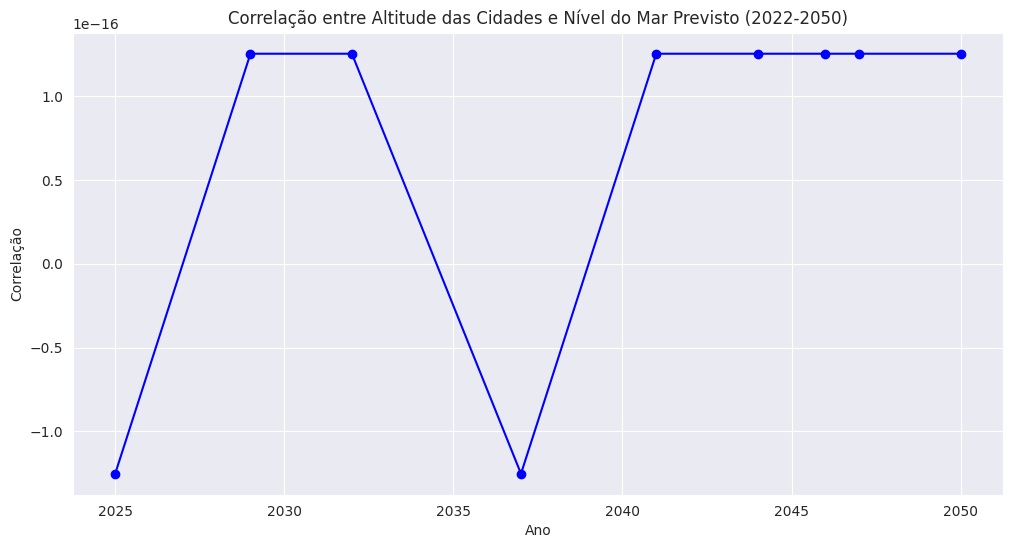

In [42]:
# Filtrando as correlações para excluir valores nan
correlations_non_nan = correlations.dropna()

# Criando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(correlations_non_nan['Year'], correlations_non_nan['Correlation'], marker='o', color='blue')
plt.title('Correlação entre Altitude das Cidades e Nível do Mar Previsto (2022-2050)')
plt.xlabel('Ano')
plt.ylabel('Correlação')
plt.grid(True)
plt.show()

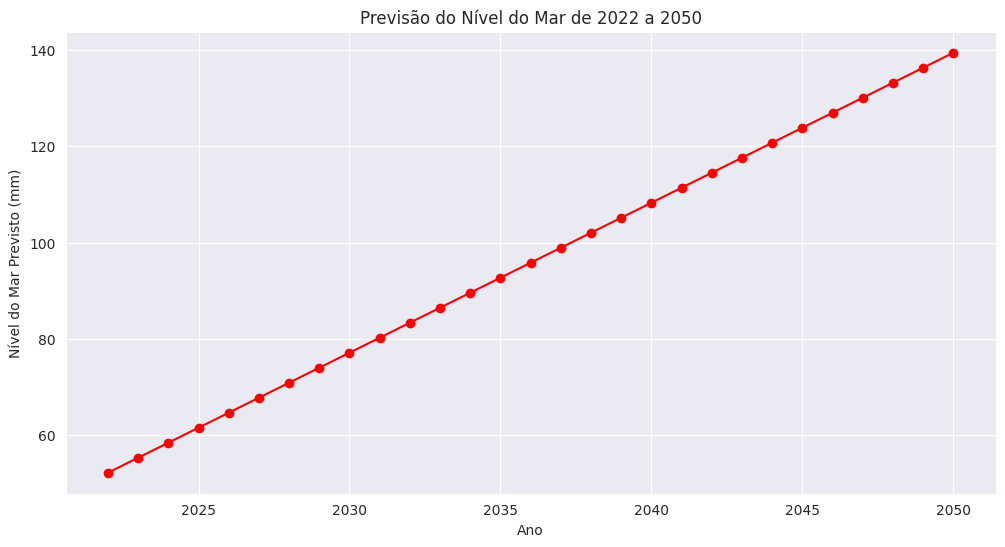

In [43]:
# Definindo o intervalo de anos para a previsão do nível do mar
future_years_extended = np.arange(2022, 2051).reshape(-1, 1)

# Realizando as previsões do nível do mar para os anos futuros
predicted_sea_levels_extended = model.predict(future_years_extended)

# Criando o gráfico com a previsão do nível do mar
plt.figure(figsize=(12, 6))
plt.plot(future_years_extended, predicted_sea_levels_extended, marker='o', color='red')
plt.title('Previsão do Nível do Mar de 2022 a 2050')
plt.xlabel('Ano')
plt.ylabel('Nível do Mar Previsto (mm)')
plt.grid(True)
plt.show()

# Criação de um Indicador de Risco
Considerando que cidades com altitude abaixo da previsão de nível do mar estão em risco

In [50]:
# Realizando as previsões do nível do mar para 2022 até 2050
predicted_sea_levels = model.predict(future_years)

In [51]:
for year, sea_level in zip(future_years.flatten(), predicted_sea_levels):
    brazil_cities_df_cleaned[f'Risk_{year}'] = brazil_cities_df_cleaned['ALT'] < sea_level

#Distribuição da Altitude das Cidades

Visualização para entender a distribuição da altitude das cidades brasileiras.

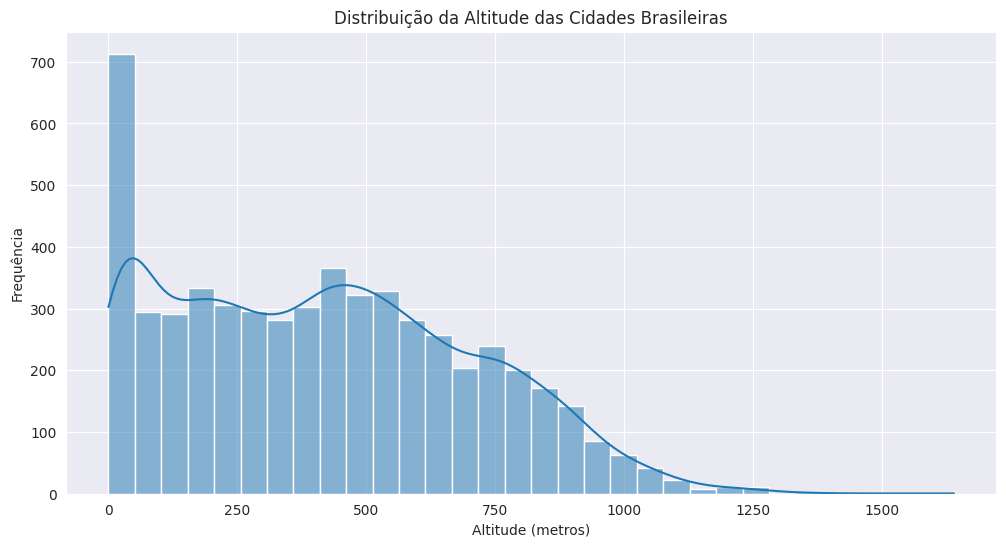

In [45]:
plt.figure(figsize=(12, 6))
sns.histplot(brazil_cities_df_cleaned['ALT'], kde=True)
plt.title('Distribuição da Altitude das Cidades Brasileiras')
plt.xlabel('Altitude (metros)')
plt.ylabel('Frequência')
plt.show()


#Boxplot da Altitude das Cidades

Visualização da distribuição da altitude, destacando outliers.

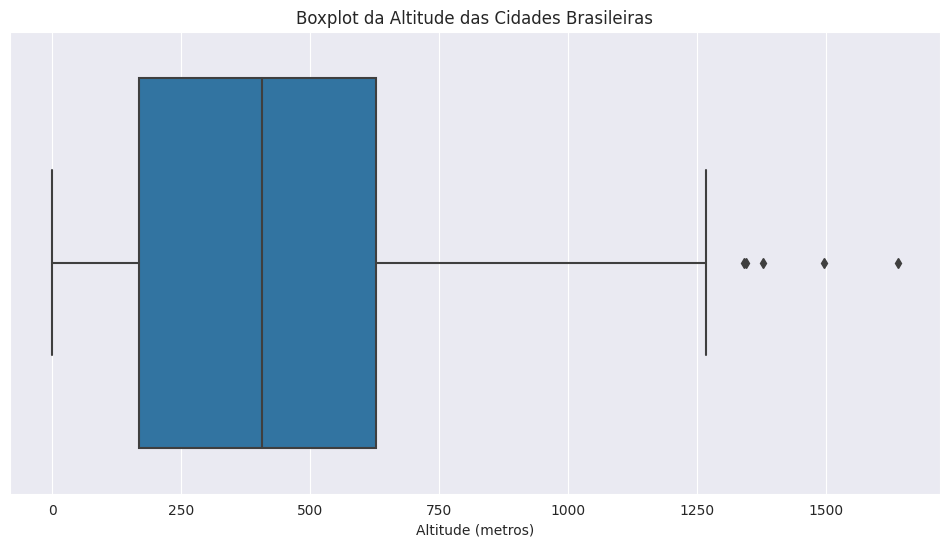

In [46]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=brazil_cities_df_cleaned['ALT'])
plt.title('Boxplot da Altitude das Cidades Brasileiras')
plt.xlabel('Altitude (metros)')
plt.show()


#Cidades Brasileiras que poderão ser submerssas com o aumento do nível do mar previsto para os próximos anos

In [52]:
submerged_cities = []

# Iterando pelos anos futuros e identificando cidades em risco
for year, sea_level in zip(future_years.flatten(), predicted_sea_levels):
    # Identificando cidades cuja altitude é menor que o nível do mar previsto
    at_risk_cities = brazil_cities_df_cleaned[brazil_cities_df_cleaned['ALT'] < sea_level]
    for index, city in at_risk_cities.iterrows():
        submerged_cities.append([year, city['City'], city['State']])

# Convertendo a lista em um DataFrame
submerged_cities_df = pd.DataFrame(submerged_cities, columns=['Year', 'City', 'State'])

# Exibindo as primeiras linhas do DataFrame
print(submerged_cities_df.head())

   Year          City State
0  2025    Abaetetuba    PA
1  2025  Abreu E Lima    PE
2  2025        Acaraú    CE
3  2025         Acará    PA
4  2025          Afuá    PA


In [53]:
# Ordenando as cidades pelo ano em que estão previstas para submergir
submerged_cities_df_sorted = submerged_cities_df.sort_values(by='Year')

# Selecionando e exibindo as primeiras 30 cidades
top_30_submerged_cities = submerged_cities_df_sorted.head(30)
print(top_30_submerged_cities)


     Year             City State
0    2025       Abaetetuba    PA
518  2025         Peritoró    MA
519  2025          Peruíbe    SP
520  2025   Pescaria Brava    SC
521  2025        Piaçabuçu    AL
522  2025            Pilar    PB
523  2025            Pilar    AL
524  2025    Pindaré-Mirim    MA
525  2025      Pindoretama    CE
526  2025  Pinhal Da Serra    RS
517  2025       Peri Mirim    MA
527  2025         Pinheiro    MA
529  2025          Pio Xii    MA
530  2025          Pirambu    SE
531  2025         Piranhas    AL
532  2025        Pirapemas    MA
533  2025          Pitimbu    PB
534  2025            Piúma    ES
535  2025           Pojuca    BA
536  2025         Pomerode    SC
537  2025  Ponta De Pedras    PA
528  2025   Pinto Bandeira    RS
516  2025            Penha    SC
515  2025           Penedo    AL
514  2025       Pendências    RN
493  2025       Paripueira    AL
494  2025    Pariquera-Açu    SP
495  2025       Parnamirim    RN
496  2025         Parnaíba    PI
497  2025 

#Conclusão e Sugestões para Continuação do Estudo

Este modelo fornece uma estimativa inicial para entender como o nível do mar pode variar com o tempo. No entanto, é importante considerar que a realidade é mais complexa. Fatores como mudanças climáticas, atividades humanas e variações geográficas específicas também influenciam o nível do mar.


Possíveis Continuações do Estudo:

**Incorporar mais variáveis:** Incluir outras variáveis relevantes, como emissões de CO2, temperatura global e atividades geológicas.

**Modelos mais complexos:** Explorar modelos de aprendizado de máquina mais sofisticados que possam capturar relações não lineares e interações entre diferentes variáveis.

**Dados mais detalhados:** Obter dados mais granulares, como medições de nível do mar em locais específicos, e correlacioná-los com altitudes das cidades brasileiras.